In [ ]:
# Collegamento a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import json
import re
from tqdm import tqdm
from PIL import Image
from skimage import morphology, measure, color, img_as_ubyte, img_as_float
from skimage.color import rgb2gray
from scipy import ndimage
from scipy.ndimage import label
import cv2
import matplotlib.pyplot as plt


def extract_last_number_from_filename(filename):
    """Estrae l'ultimo numero nel nome del file."""
    # Trova tutti i numeri nel nome del file
    numbers = re.findall(r'\d+', filename)
    # Restituisce l'ultimo numero trovato, se esiste, altrimenti 0
    return int(numbers[-1]) if numbers else 0

def count_connected_objects(volume):
    """Count the number of connected components in a binary volume."""
    labeled_volume = measure.label(volume, connectivity=1)
    num_objects = np.max(labeled_volume)
    return num_objects

def calculate_absolute_error(pred_count, gt_count):
    """Calculate the absolute error in counting connected objects."""
    error = abs(gt_count - pred_count)
    return error


# Funzione per calcolare il Temporal Stability Index (TSI)
def calculate_tsi(mask1, mask2):
    """Calculate the Temporal Stability Index (TSI) between two binary masks."""
    # Converte le maschere in formato binario e tipo float64
    mask1 = np.array(mask1, dtype=np.float64)
    mask2 = np.array(mask2, dtype=np.float64)
    area1 = np.sum(mask1)
    area2 = np.sum(mask2)

    # Evita divisioni per zero
    if area1 + area2 == 0:
        return 0.0

    # Calcola il TSI basato sulla variazione dell'area
    tsi = abs(area1 - area2) / (area1 + area2)
    return tsi

def detect_and_remove_specular_highlights(image):

    image_array = np.array(image)
    gray=rgb2gray(image_array)
    gray=(gray * 255).astype(np.uint8)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.dilate(mask, kernel, iterations=2)
    corrected_image = cv2.inpaint(image_array, mask, 5, cv2.INPAINT_TELEA)

    return corrected_image, mask

def regional_masking_and_inpainting(img, discontinuity_threshold=1 * 10**(-2)):

        # Converti l'immagine in array numpy
        img_array = np.array(img)

        # Converte in toni di grigio per calcolare i gradienti
        gray_image = color.rgb2gray(img_array)
        J = np.array(gray_image)

        # Definire il kernel derivativo base
        hx = np.array([[-1, 0, 1]])
        hy = np.array([[-1], [0], [1]])

        # Ricavare i gradienti orizzontale e verticale
        Jx = ndimage.correlate(J, hx)
        Jy = ndimage.correlate(J, hy)

        # Identifica la riga centrale
        central_row = Jx[Jx.shape[0] // 2, :]

        # Calcola le differenze tra pixel adiacenti
        diff = np.abs(np.diff(central_row))

        # Trova il primo indice con discontinuità (da sinistra)
        left_bound = np.argmax(diff > discontinuity_threshold)
        # Trova il primo indice con discontinuità (da destra)
        right_bound = len(diff) - np.argmax(diff[::-1] > discontinuity_threshold) - 1

        # Applica la modifica dei pixel sull'immagine a colori
        modified_image = img_array.copy()
        modified_image[:, :left_bound, :] = 16  # Imposta a 16 i pixel a sinistra di left_bound
        modified_image[:, right_bound:, :] = 16  # Imposta a 16 i pixel a destra di right_bound

        # Reset a zero i pixel con tutti i canali pari a 16
        reset_image = modified_image.copy()
        mask = (reset_image[:, :, 0] == 16) & (reset_image[:, :, 1] == 16) & (reset_image[:, :, 2] == 16)
        reset_image[mask] = [0, 0, 0]  # Imposta a [0, 0, 0] i pixel corrispondenti

        # Esegui l'inpainting sull'immagine croppata
        corrected_image, specular_mask = detect_and_remove_specular_highlights(reset_image)


        return corrected_image

def normalizza_immagine(img_path):
    # Read grayscale image
    image = Image.open(img_path)
    image_array=np.array(image)
    # Normalize image
    normalized_image = cv2.normalize(
      image_array, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    return Image.fromarray(normalized_image)


# Funzione per rimuovere regioni connesse minori di una soglia
def remove_small_regions(mask, min_size):
    # Identifica le regioni connesse
    labeled_mask, num_features = label(mask)
    # Crea una maschera vuota
    filtered_mask = np.zeros_like(mask, dtype=np.uint8)
    # Mantieni solo le regioni connesse maggiori della soglia
    for region_label in range(1, num_features + 1):
        region = (labeled_mask == region_label)
        if np.sum(region) >= min_size:
            filtered_mask[region] = 1
    return filtered_mask



In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.manifold import TSNE  # Importa TSNE
import matplotlib.pyplot as plt
import pickle
from matplotlib import cm
from skimage.color import rgb2gray
new_size=(256,256)
discontinuity_threshold=1 * 10**(-2)

def load_images(dataset_path, target_size=(256, 256)):
    """Carica tutte le immagini dal dataset, rispettando la struttura del dataset descritto nello script di divisione."""
    images = []
    labels = []  # Per tracciare provenienza (centro o sequenza)

    # Esplora le cartelle principali (centri e sequenze)
    for main_dir in os.listdir(dataset_path):
        main_path = os.path.join(dataset_path, main_dir)

        # Se si tratta di un centro (data_Cx)
        if main_dir.startswith("data_C") and os.path.isdir(main_path):
            center_id = main_dir[-1]  # Estrai l'ID del centro (1-6)
            image_dir = os.path.join(main_path, f"images_C{center_id}")
            if os.path.exists(image_dir):
                for img_name in os.listdir(image_dir):
                    img_path = os.path.join(image_dir, img_name)
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        try:
                            img = Image.open(img_path)
                            img = img.resize(target_size)  # Ridimensiona l'immagine
                            corrected_image=regional_masking_and_inpainting(img, discontinuity_threshold)

                            corrected_image_pil = Image.fromarray(img_as_ubyte(corrected_image))



                            # Save img to temporary file
                            corrected_image_pil.save('tmp_img.png')

                            image_modified=normalizza_immagine('tmp_img.png')
                            images.append(np.array(image_modified).flatten())
                            labels.append(main_dir)
                        except Exception as e:
                            print(f"Errore nel caricamento immagine {img_path}: {e}")

         # Se si tratta di una sequenza (seqX)
        elif main_dir.startswith("sequenceData") and os.path.isdir(main_path):
            image_dir1 = os.listdir(main_path)
            for a in image_dir1:
              image_dir = os.path.join(main_path, a, f"images_{a}")
              if os.path.exists(image_dir):
                  for img_name in os.listdir(image_dir):
                      img_path = os.path.join(image_dir, img_name)
                      if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                          try:
                              img = Image.open(img_path)
                              img = img.resize(target_size)  # Ridimensiona l'immagine
                              corrected_image=regional_masking_and_inpainting(img, discontinuity_threshold)

                              corrected_image_pil = Image.fromarray(img_as_ubyte(corrected_image))



                              # Save img to temporary file
                              corrected_image_pil.save('tmp_img.png')

                              image_modified=normalizza_immagine('tmp_img.png')
                              images.append(np.array(image_modified).flatten())  # Appiattisci l'immagine
                              labels.append(main_dir)
                          except Exception as e:
                              print(f"Errore nel caricamento immagine {img_path}: {e}")

    return np.array(images), labels


# Percorsi principali
dataset_path = "/content/drive/MyDrive/CHALLENGE_NUOVA_CARTELLA/PolypGen-EIM-24-25"


# Caricamento immagini
print("Caricamento immagini dal dataset...")
images, labels = load_images(dataset_path)
print(f"Numero totale di immagini caricate: {len(images)}")



Caricamento immagini dal dataset...
Numero totale di immagini caricate: 3762


<ipython-input-4-2f6d6a04211b>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(unique_labels))  # Usa una mappa con 10 colori (o più se necessario)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TSNE from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Piano TSNE caricato da: /content/drive/MyDrive/CHALLENGE_NUOVA_CARTELLA/tsne_plane.pkl


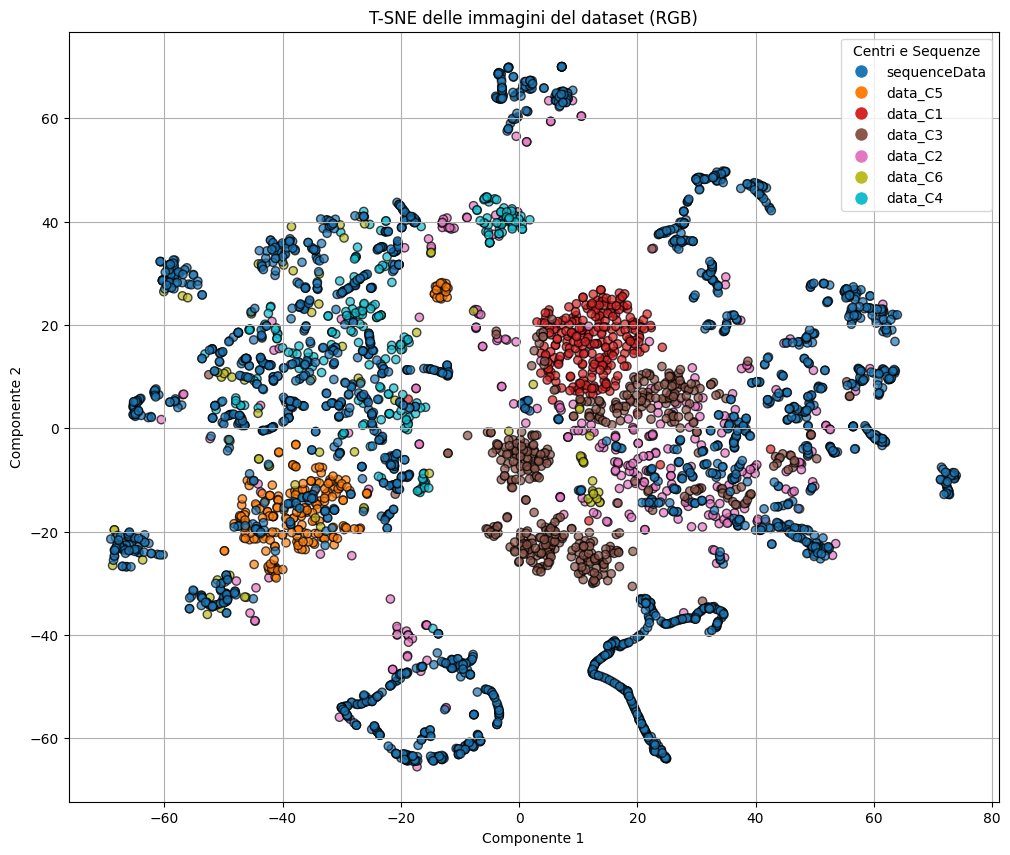

Elaborazione completata con successo.


In [ ]:
# Assegna colori alle etichette
unique_labels = list(set(labels))  # Trova etichette uniche (centri e sequenze)
label_to_color = {label: i for i, label in enumerate(unique_labels)}  # Mappa etichetta -> indice
colors = [label_to_color[label] for label in labels]  # Converte etichette in indici numerici

# Usare una mappa colori
colormap = cm.get_cmap('tab10', len(unique_labels))  # Usa una mappa con 10 colori (o più se necessario)
color_values = [colormap(c) for c in colors]  # Ottieni colori per ogni punto

# Caricamento del modello T-SNE
output_tsne_path = '/content/drive/MyDrive/CHALLENGE_NUOVA_CARTELLA/tsne_plane.pkl'
with open(output_tsne_path, 'rb') as f:
    tsne = pickle.load(f)
print(f"Piano TSNE caricato da: {output_tsne_path}")

# Applica T-SNE alle nuove immagini
tsne_result = tsne.fit_transform(images)  # Applicazione del piano TSNE

# Plot dei risultati
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, c=color_values, edgecolor='k')
plt.title('T-SNE delle immagini del dataset (RGB)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

# Aggiungi legenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10) for i in range(len(unique_labels))]
plt.legend(handles, unique_labels, title="Centri e Sequenze", loc="best")

plt.grid(True)
plt.savefig("tsne_plot_colored.png")  # Salva il grafico
plt.show()

print("Elaborazione completata con successo.")


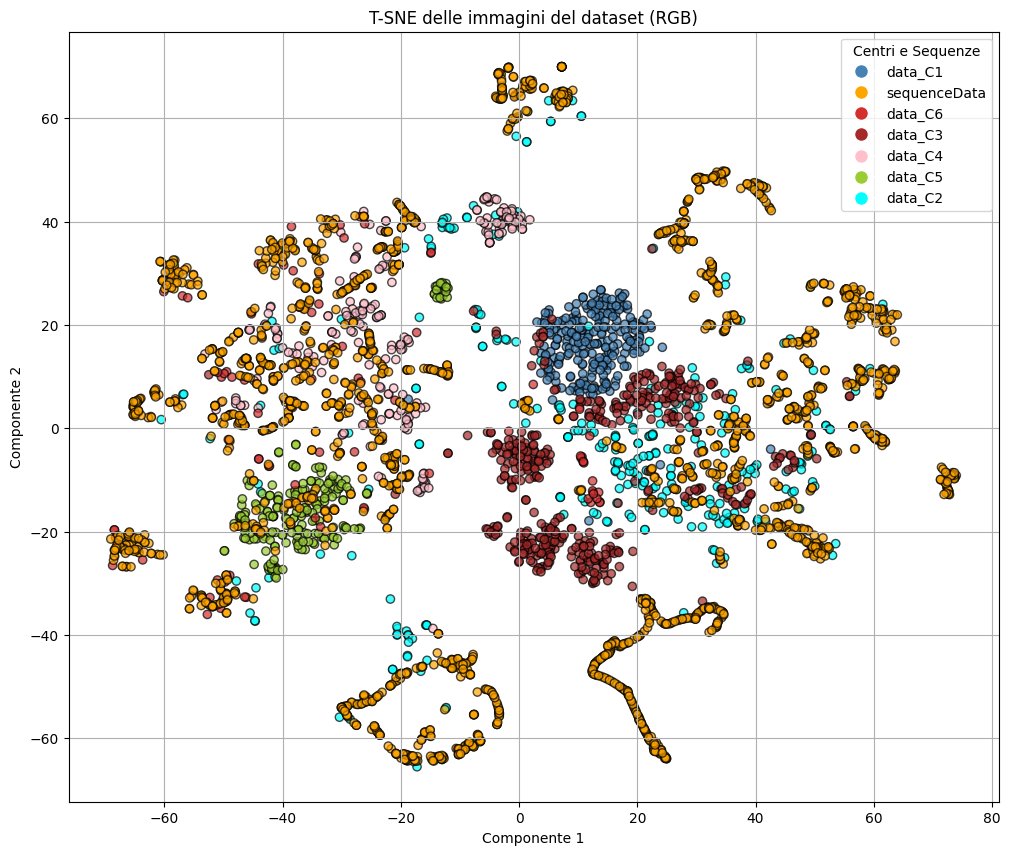

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Etichette e ordine desiderato
desired_order = ['data_C1', 'sequenceData', 'data_C6', 'data_C3', 'data_C4', 'data_C5', 'data_C2']

# Colori specifici per l'ordine desiderato
custom_colors = {
    'data_C1': '#4682B4',
    'sequenceData': 'orange',
    'data_C6': '#D32F2F',
    'data_C3': 'brown',
    'data_C4': 'pink',
    'data_C5': 'yellowgreen',  # Verde pisello
    'data_C2': 'cyan'  # Celeste
}

# Mappa le etichette in base all'ordine desiderato
label_to_color = {label: custom_colors[label] for label in desired_order}
colors = [label_to_color[label] for label in labels]


# Plot t-SNE con i colori definiti
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, c=colors, edgecolor='k')
plt.title('T-SNE delle immagini del dataset (RGB)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

# Aggiungi legenda ordinata manualmente
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_colors[label], markersize=10)
    for label in desired_order
]
plt.legend(handles, desired_order, title="Centri e Sequenze", loc="best")

plt.grid(True)
plt.savefig("tsne_plot_colored_ordered.png")  # Salva il grafico
plt.show()


In [ ]:
# Varianza dopo il T-SNE (ORIGINALE)
tsne_variance = np.var(tsne_result, axis=0).sum()

print(f"Varianza dopo il T-SNE: {tsne_variance}")

Varianza dopo il T-SNE: 2001.8836669921875
